# Алгоритм Брэдли #

## Подключаем нужные библиотеки ##

In [1]:
%matplotlib inline

import pathlib
import imageio
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray

## Загружаем ДатаСет ##

In [2]:
training_paths = pathlib.Path('1 - Image/Dataset').glob('*')
training_sorted = sorted([x for x in training_paths])

## Реализация алгоритма бинаризации изображения ##

d - размер окна, по которому идет оценка 

d_h - половина размера окна, т.к нам удобнее работать именно с ней 

sz - подобранный параметр, для измерения размера окна 

coef - подобранный параметр для нахождению трешхолда 

S - матрица интегрального изображения


### Реализация ### 

1. В цикле заполняем нашу матрицу интегрального изображения, добавляем отсутп в виде нулей, для недопущения уменьшения размера кратинки
2. Трешхолд высчитывается как среднее по окну + coef * среднее
3. За полняем изображение поэлементно

In [15]:
%%time

        
def binarizeImage(image, sz, coef):
    d = image.shape[0] // (int)(sz)
    
    d_h = d // 2
    
    s = np.pad(image, d_h, mode = 'constant')
    
    for i in (range(d_h, image.shape[0])):
        for j in range(d_h, image.shape[1]):
            s[i, j] = s[i, j] + (s[i - 1, j] + s[i, j - 1] - s[i - 1, j - 1])
    
    
    def thresholding(ar):
        i = (int)(ar[0])
        j = (int)(ar[1])
        x = ar[2]
        im = (s[i, j] 
             + s[i + 2 * (d_h), j + 2 * (d_h)]
             - s[i + 2 * (d_h), j]
             - s[i, j + 2 * (d_h)]) / ((d_h * 2) ** 2)
        
        t = im * coef
        threshold = im + t
        if (x >= threshold):
            return 1
        else:
            return 0
    
    
    out_image = np.apply_along_axis(thresholding, 
                                    2, 
                                    np.dstack((*np.mgrid[:image.shape[0], :image.shape[1]], image)))
    
    return out_image
            
    
    

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.4 µs


CPU times: user 9min 29s, sys: 4.07 s, total: 9min 33s
Wall time: 9min 36s


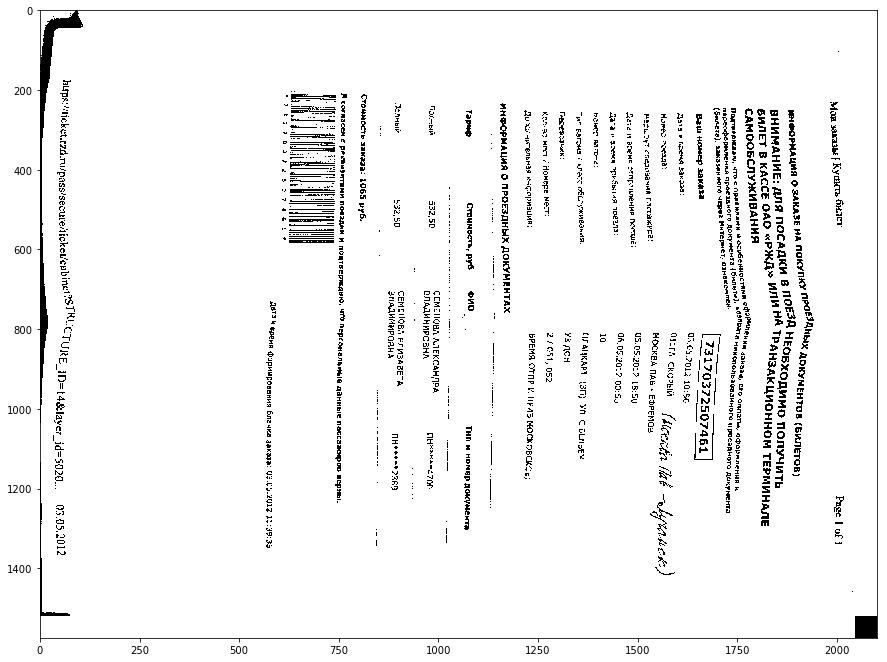

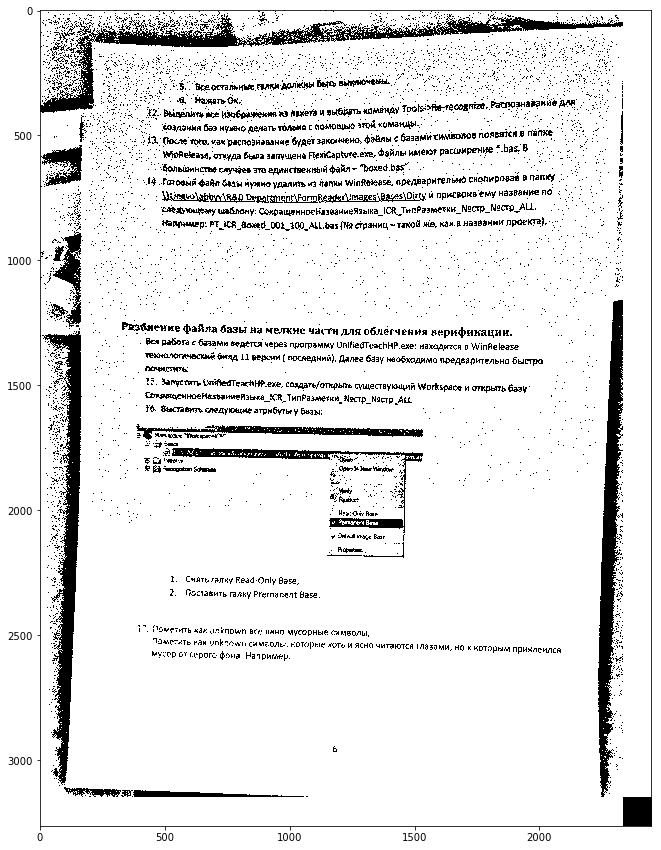

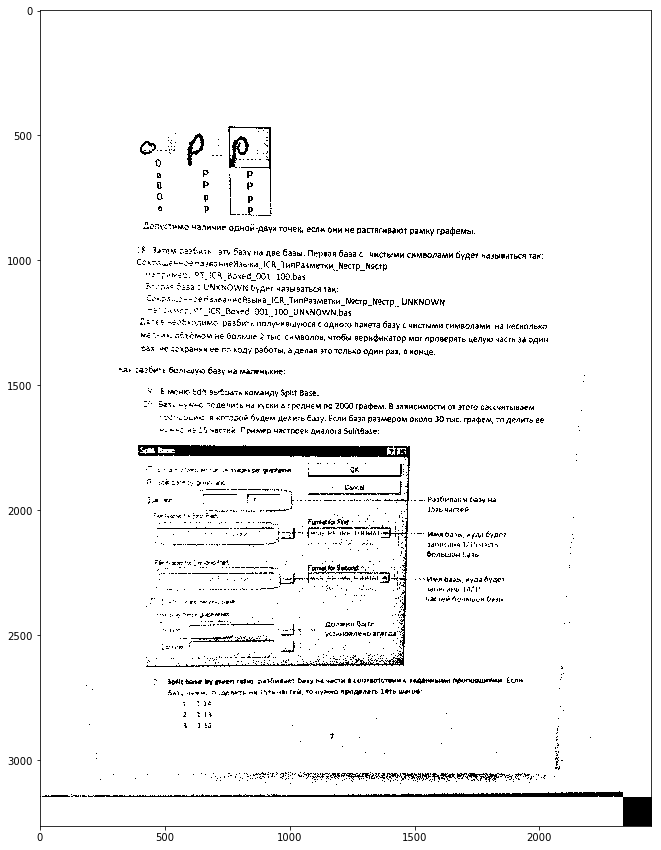

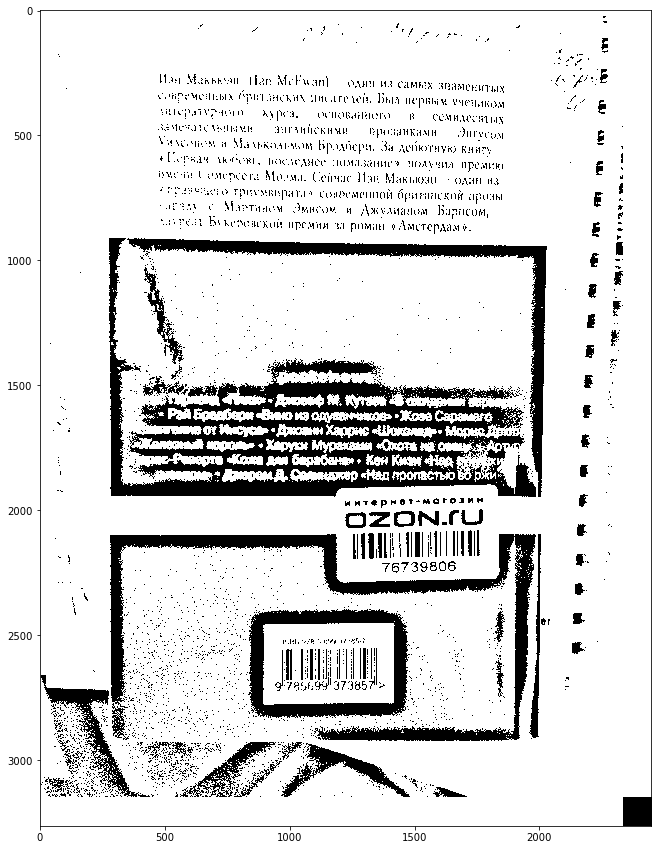

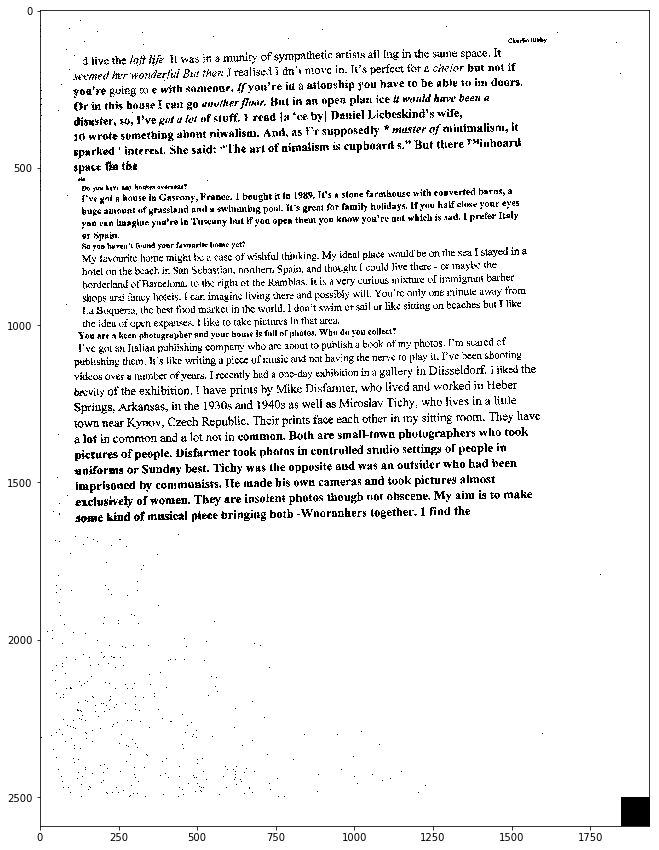

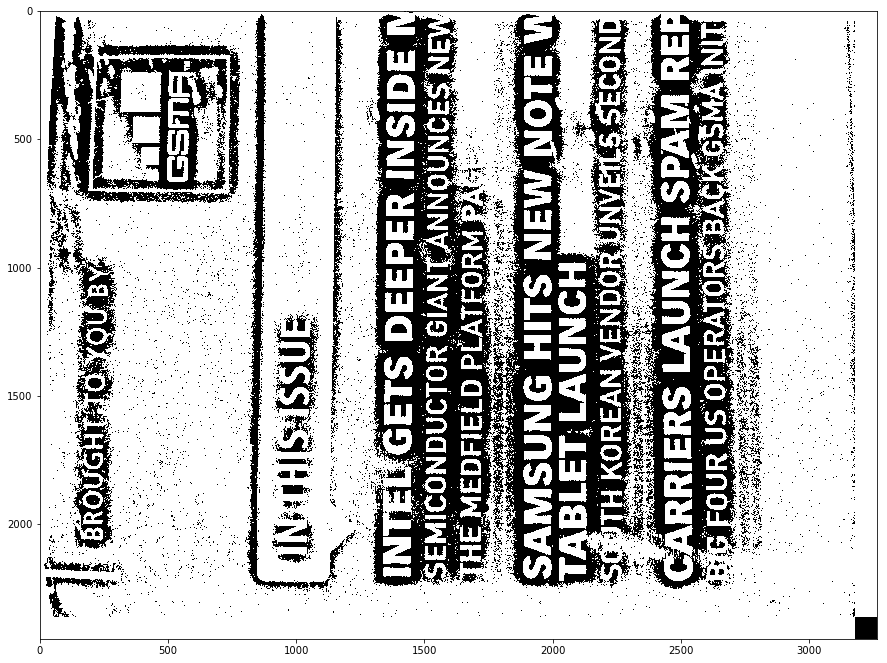

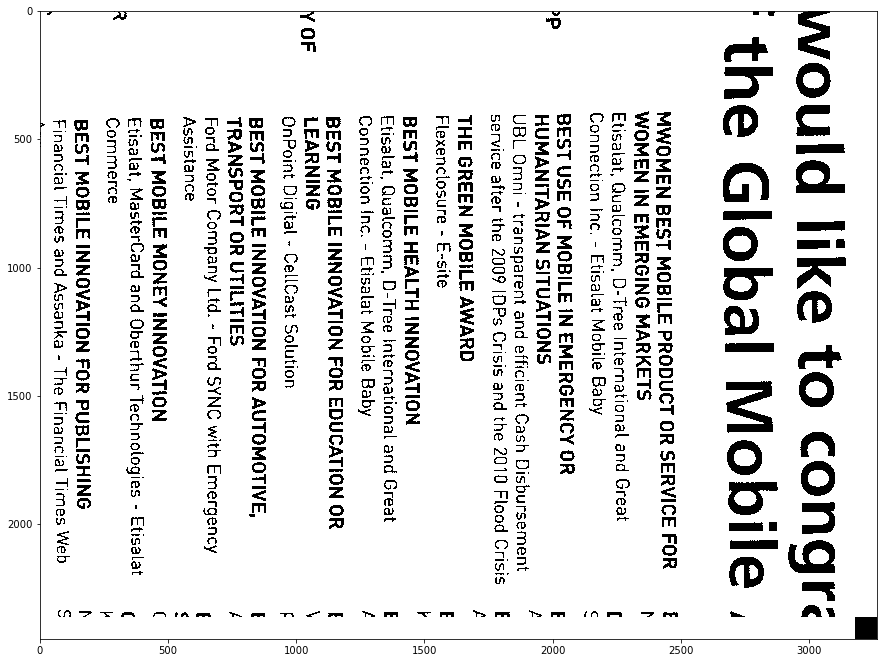

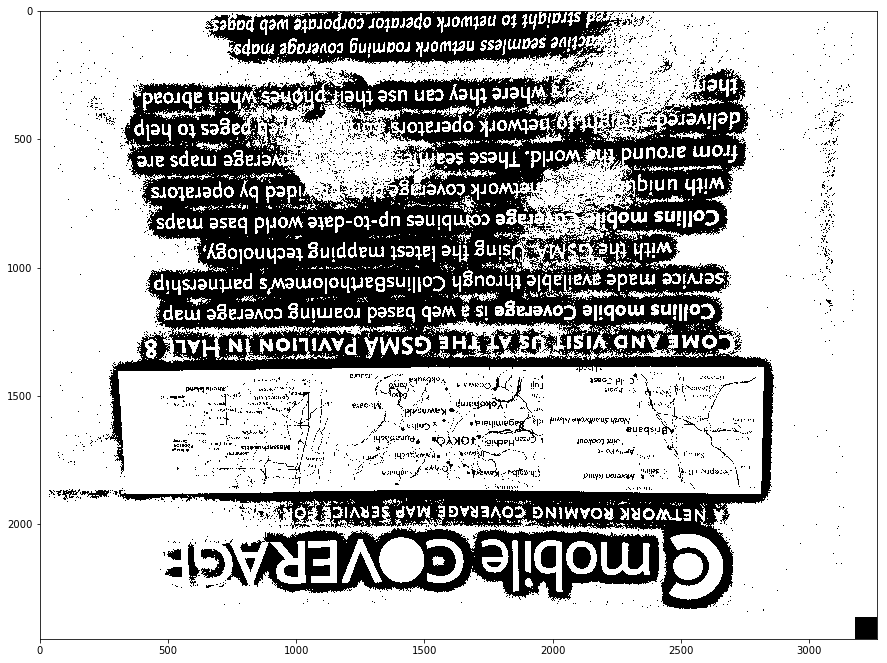

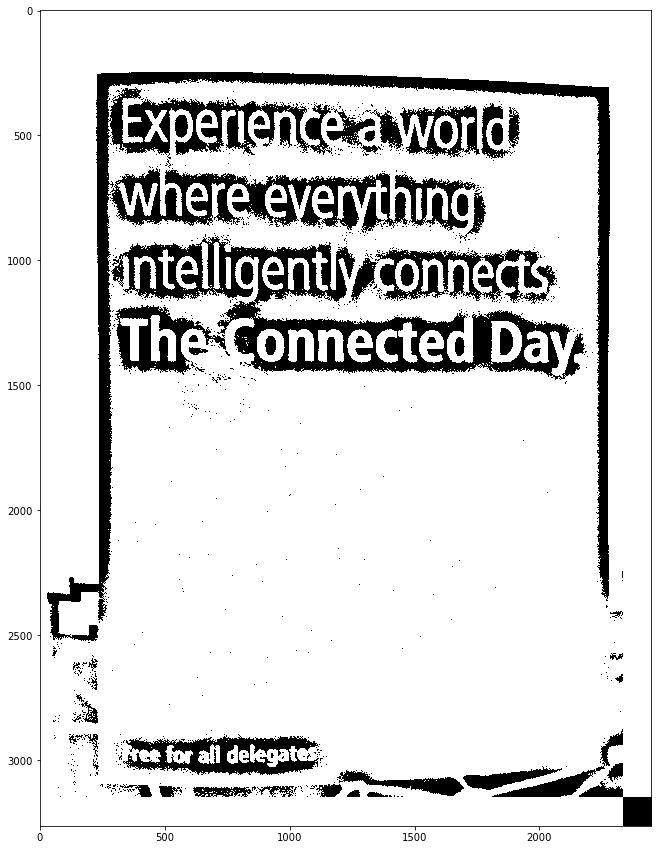

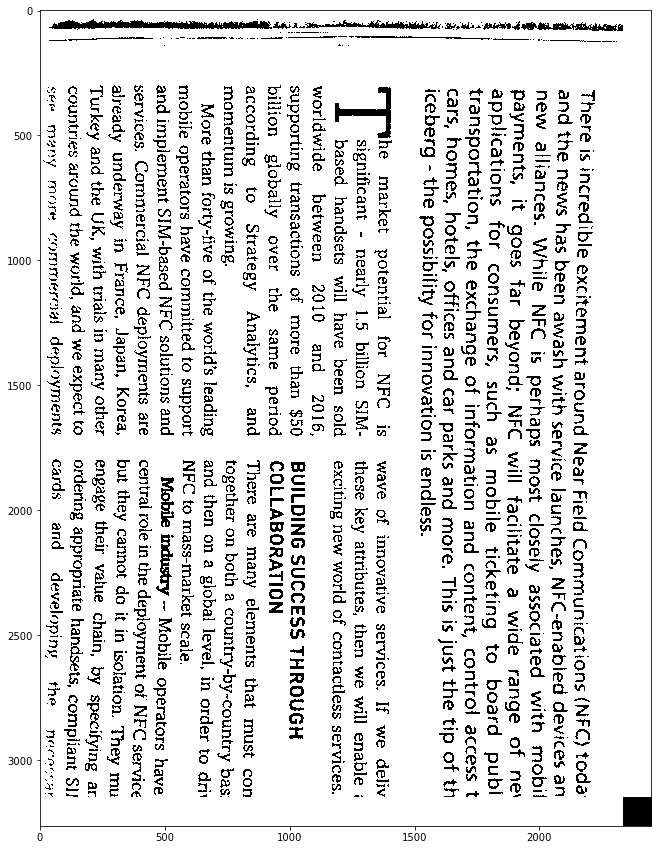

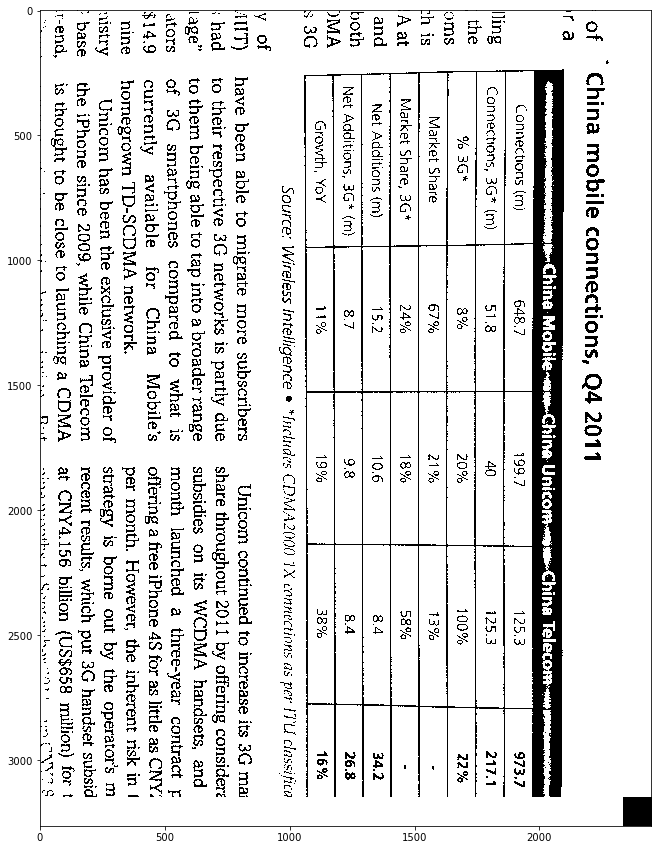

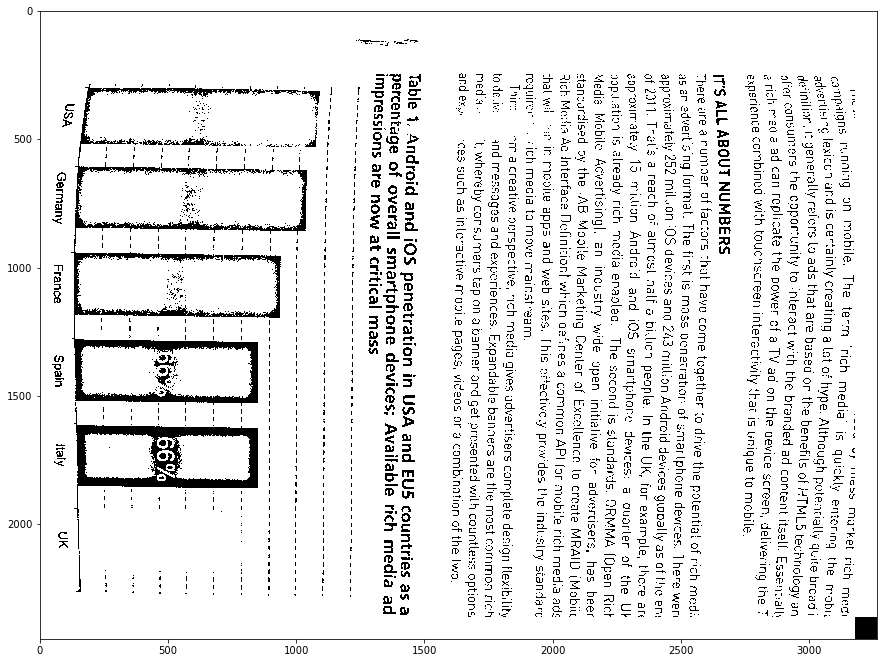

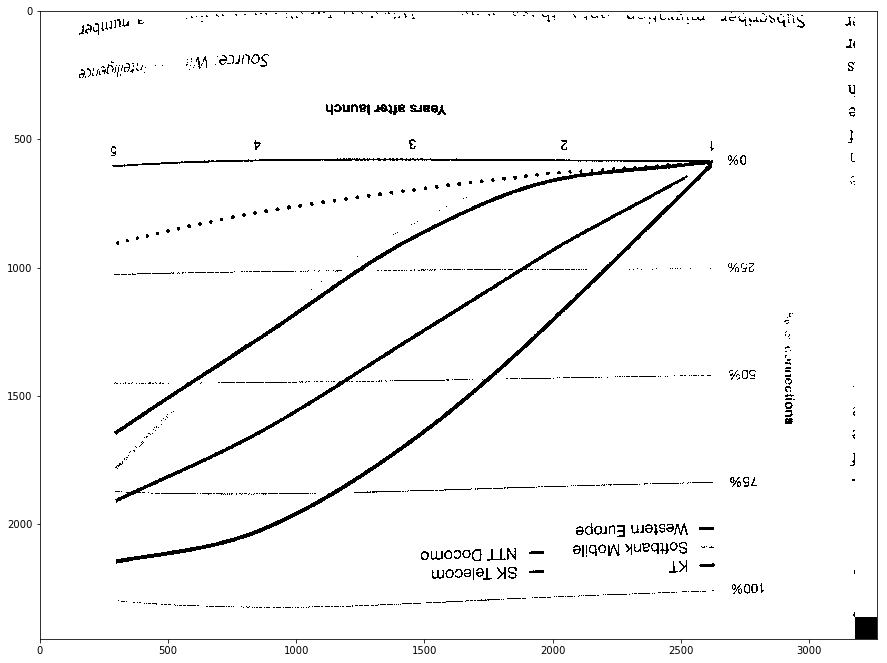

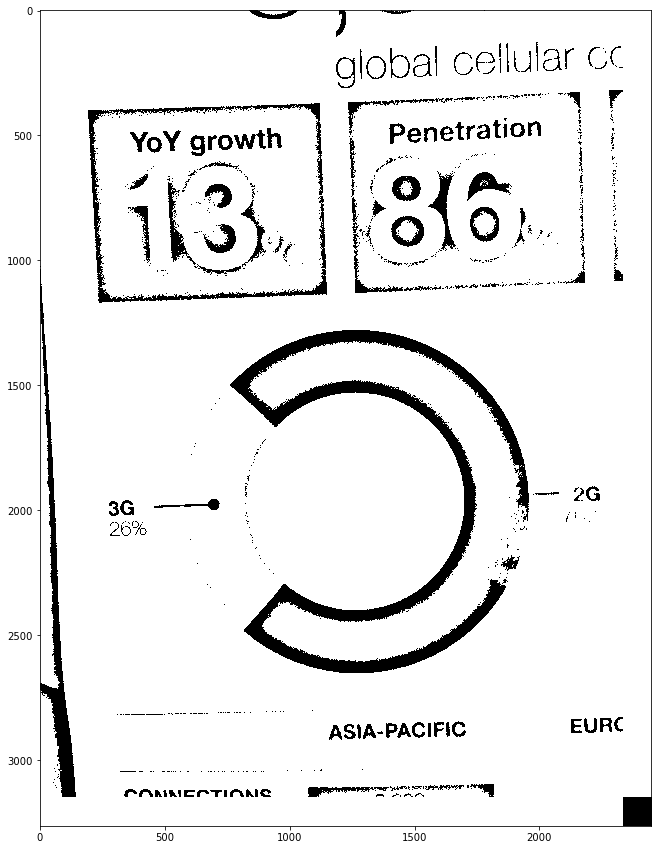

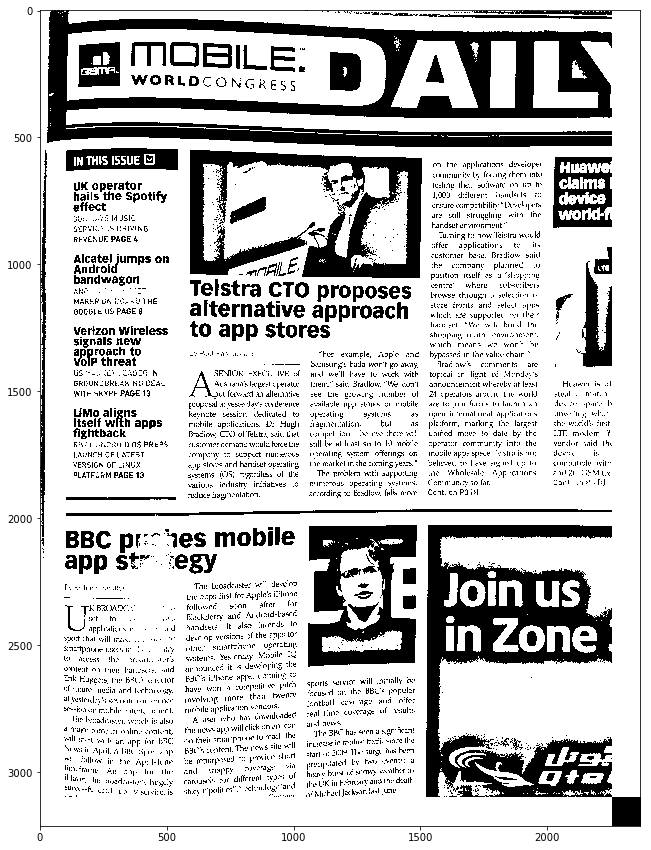

In [16]:
%%time

for (i, path) in enumerate(training_sorted):
    image = imageio.imread(str(path))
    plt.figure(figsize=(15, 15))
    binary_image = binarizeImage(rgb2gray(image), 28.55, -0.1869).astype(np.uint8) # 25.5, -0.1899)
    plt.imshow(rgb2gray(image), cmap=plt.cm.gray)
    plt.imshow(binary_image, cmap=plt.cm.gray)
    plt.imsave('res_images2/image' + str(i) + '.png', binary_image, cmap=plt.cm.gray)
    #break
    
    

## Оценка времени работы ##

### Проведем теоритическую оценку времени работы алгоритма: ###

Пусть размер изображения в пикселях N (N = width * heigth)

1. Перевод в черно-белое изображение, вернее в серое занимает порядка N операций
2. Вычисляем матрицу S за N операции
3. Проходим по изображению и делаем картинку черно-белой за N операции
4. И того 3 * N операций

Код написанный на CPython выполняет примерно 70 000 000 операций за одну секунду,

значит время обработки изображения $\frac{3 * N} { 70 000 000}$


Если изображение 3000 * 2000 пикселей, то время работы составит 0.25 секунд.



## Результаты ##

В некоторых местах текст получился белого, а не черного цвета, можно поправить, если проверить каков является фон изображения.

Некоторые фотографии зашумлены, можно попытаться изначально удалить шум, а потом бинаризовать, или еще больше поэкспериментировать с параметрами.

В некоторых изображениях текст бледный, на них можно уменьшить трешхолд. Вообще не мешало бы выбирать параметры трешхолда, т.е параметр размера окна относительно всего изображения и коэффициент, на который умножаем трешхолд, исходя из анализа каждого отдельного изображения